In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from econml.metalearners import XLearner, SLearner, TLearner
from lightgbm import LGBMClassifier

from pathlib import Path
import polars as pl

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


In [2]:
# train
from featurization import featurize_data
from data_ingestion import ingest_and_pre_process_data

train_dfs = ingest_and_pre_process_data(Path('./data/train'))
# train_dfs['claims'] = train_dfs['claims'].filter(pl.col('icd_code').is_in(['E11.9', 'I10', 'Z71.3']))
train_features_w_labels = featurize_data(train_dfs)

train_features = train_features_w_labels.drop(['member_id', 'churn', 'outreach'])

# T = outreach, Y = churn
cate_model = XLearner(models=LGBMClassifier(max_depth=5, 
                                            n_estimators=1000,
                                            reg_alpha=0.1,
                                            reg_lambda=0.1,),
 )
                    #   allow_missing=True,
                    #   propensity_model=HistGradientBoostingClassifier())

# cate_model = TLearner(models=LGBMClassifier(),
#                       allow_missing=True,)

cate_model.fit(Y=1-train_features_w_labels['churn'].to_numpy(), 
               T=train_features_w_labels['outreach'].to_numpy(), 
               X=train_features.to_numpy())

# Get conditional treatment effect
train_te = cate_model.effect(train_features.to_numpy())

[LightGBM] [Info] Number of positive: 4768, number of negative: 1248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 6016, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.792553 -> initscore=1.340385
[LightGBM] [Info] Start training from score 1.340385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
# train

train_eval_df = pl.DataFrame({'te': train_te, 
                        'member_id': train_features_w_labels['member_id'],
                        'outreach': train_features_w_labels['outreach'],
                        'churn': train_features_w_labels['churn'],})

train_fpr, train_tpr, train_thresholds = roc_curve(train_eval_df.filter(pl.col('churn')==1)['outreach'], 
                                 -train_eval_df.filter(pl.col('churn')==1)['te'])

train_fpr, train_tpr, train_thresholds = roc_curve(train_eval_df.filter(pl.col('churn')==0)['outreach'], 
                                 train_eval_df.filter(pl.col('churn')==0)['te'])

# train_fpr, train_tpr, train_thresholds = roc_curve(train_eval_df['outreach'], 
#                                  train_eval_df['te'])

roc_auc = auc(train_fpr, train_tpr)

roc_auc

np.float64(0.5918110772742188)

Text(0, 0.5, 'Density')

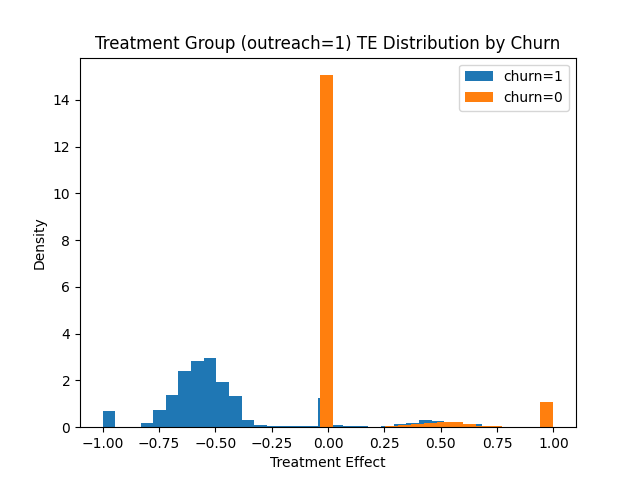

In [21]:
%matplotlib widget
df_or1_churn1 = train_eval_df.filter(pl.col('outreach')==1).filter(pl.col('churn')==1)
df_or1_churn0 = train_eval_df.filter(pl.col('outreach')==1).filter(pl.col('churn')==0)

plt.figure()
plt.hist(df_or1_churn1['te'].to_numpy(), bins=30, density=True, label='churn=1')
plt.hist(df_or1_churn0['te'].to_numpy(), bins=30, density=True, label='churn=0')

legend = plt.legend(loc='upper right')
plt.title('Treatment Group (outreach=1) TE Distribution by Churn')
plt.xlabel('Treatment Effect')
plt.ylabel('Density')

In [5]:
# test
from featurization import featurize_data
from data_ingestion import ingest_and_pre_process_data

test_dfs = ingest_and_pre_process_data(Path('./data/test'))
# test_dfs['claims'] = test_dfs['claims'].filter(pl.col('icd_code').is_in(['E11.9', 'I10', 'Z71.3']))
test_features_w_labels = featurize_data(test_dfs)

test_features = test_features_w_labels.drop(['member_id', 'churn', 'outreach'])

# Get conditional treatment effect
test_te = cate_model.effect(test_features.to_numpy())

In [6]:

# test

test_eval_df = pl.DataFrame({'te': test_te, 
                        'member_id': test_features_w_labels['member_id'],
                        'outreach': test_features_w_labels['outreach'],
                        'churn': test_features_w_labels['churn'],})

test_fpr, test_tpr, test_thresholds = roc_curve(test_eval_df.filter(pl.col('churn')==0)['outreach'], 
                                 test_eval_df.filter(pl.col('churn')==0)['te'])

test_fpr, test_tpr, test_thresholds = roc_curve(test_eval_df.filter(pl.col('churn')==1)['outreach'], 
                                 -test_eval_df.filter(pl.col('churn')==1)['te'])

roc_auc = auc(test_fpr, test_tpr)

roc_auc

np.float64(0.48476583569309595)

In [15]:
results_top_n = test_eval_df.clone()

results_top_n = results_top_n.rename({'te': 'prioritization_score'})
results_top_n = results_top_n.sort(by='prioritization_score', descending=True)
results_top_n = results_top_n.with_columns(pl.int_range(1, results_top_n.height + 1).alias('rank'))

results_top_n = results_top_n[['member_id', 'prioritization_score', 'rank']]

In [16]:
results_top_n

member_id,prioritization_score,rank
i64,f64,i64
51,1.0,1
62,1.0,2
64,1.0,3
83,1.0,4
139,1.0,5
…,…,…
8507,-1.0,9996
9079,-1.0,9997
9534,-1.0,9998


In [9]:
test_eval_df.filter(pl.col('te')<-0.5).filter(pl.col('outreach')==1)['churn'].describe()

statistic,value
str,f64
"""count""",169.0
"""null_count""",0.0
"""mean""",0.260355
"""std""",0.440132
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [41]:
import numpy as np

D_mu0_train = cate_model.models[0].predict_proba(train_features.to_numpy())[:, 0]
D_mu1_train = cate_model.models[1].predict_proba(train_features.to_numpy())[:, 1]

D_mu0_test = cate_model.models[0].predict_proba(test_features.to_numpy())[:, 0]
D_mu1_test = cate_model.models[1].predict_proba(test_features.to_numpy())[:, 1]


print([np.mean(D_mu0_train), np.mean(D_mu1_train)])
print([np.std(D_mu0_train), np.std(D_mu1_train)])

print([np.mean(D_mu0_test), np.mean(D_mu1_test)])
print([np.std(D_mu0_test), np.std(D_mu1_test)])


[np.float64(0.7857577357886003), np.float64(0.17621864397327228)]
[np.float64(0.13225347501204462), np.float64(0.13625693097192232)]
[np.float64(0.7908178466930752), np.float64(0.17454974721503594)]
[np.float64(0.12020072939106433), np.float64(0.1256281764068578)]


/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/yishaie/work/vi-exercise/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train AUUC Score: 0.2103644150502235


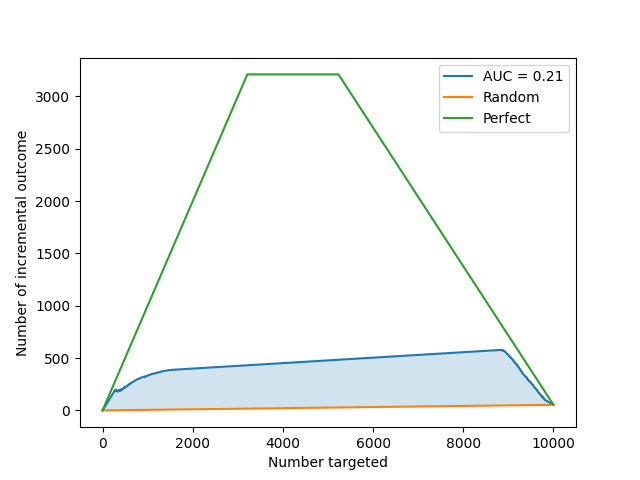

In [6]:
%matplotlib widget
from sklift.metrics import uplift_at_k, qini_auc_score
from sklift.viz import plot_qini_curve

auuc_score = qini_auc_score(y_true=1-train_eval_df['churn'], 
                            uplift=train_eval_df['te'], 
                            treatment=train_eval_df['outreach'])
print(f"Train AUUC Score: {auuc_score}")

plot_qini_curve(y_true=1-train_eval_df['churn'],
                uplift=train_eval_df['te'],
                treatment=train_eval_df['outreach'],
                )

plt.legend(loc='upper right')

Train AUUC Score: 0.0006353754214020932


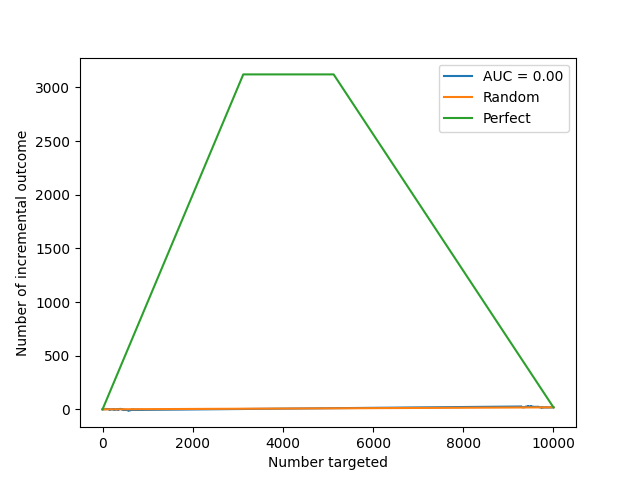

In [7]:
%matplotlib widget
from sklift.metrics import uplift_at_k, qini_auc_score
from sklift.viz import plot_qini_curve

auuc_score = qini_auc_score(y_true=1-test_eval_df['churn'], 
                            uplift=test_eval_df['te'], 
                            treatment=test_eval_df['outreach'])
print(f"Train AUUC Score: {auuc_score}")

plot_qini_curve(y_true=1-test_eval_df['churn'],
                uplift=test_eval_df['te'],
                treatment=test_eval_df['outreach'],
                )

plt.legend(loc='upper right')

In [9]:
test_te

array([0., 0., 0., ..., 0., 0., 0.], shape=(10000,))